In [60]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../')
import utils as u
u.check_python_version()
u.check_virtual_memory()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]
Virtual memory usage - total: 252 GB / available: 76 GB / percent used: 69.6 %


In [2]:
ds = xr.open_dataset('/home/msantola/TP_CLiMAF/ReferenceSNOW/SNC/SNCRefData/snowc.mon.noaaV2c_185101_201412_2.0x1.75.nc')
ds

<xarray.Dataset>
Dimensions:    (lat: 94, lon: 192, nbnds: 2, time: 1968)
Coordinates:
  * lat        (lat) float32 88.542 86.6531 84.7532 ... -86.6531 -88.542
  * lon        (lon) float32 0.0 1.875 3.75 5.625 ... 354.375 356.25 358.125
  * time       (time) datetime64[ns] 1851-01-01 1851-02-01 ... 2014-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    snowc      (time, lat, lon) float32 ...
Attributes:
    Conventions:             CF-1.2
    title:                   4x Daily NOAA-CIRES 20th Century Reanalysis V2c
    platform:                Model
    institution:             NOAA ESRL Physical Sciences Division & CU/CIRES ...
    citation:                Compo,G.P. <http://www.esrl.noaa.gov/psd/people/...
    version:                 2c
    contact:                 esrl.psd.data@noaa.gov
    source:                  20CRv2c 2014, Ensemble Kalman Filter, ocean (spe...
    forcing_note:            Additional information on the exte

In [13]:
da = ds.snowc.sel(time=slice('1984', '2014'))
da

<xarray.DataArray 'snowc' (time: 372, lat: 94, lon: 192)>
[6713856 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.542 86.6531 84.7532 ... -84.7532 -86.6531 -88.542
  * lon      (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.375 356.25 358.125
  * time     (time) datetime64[ns] 1984-01-01 1984-02-01 ... 2014-12-01
Attributes:
    long_name:         Monthly Snow Cover at Surface
    cell_methods:      time: mean (monthly from 3-hourly values)
    units:             %
    precision:         2
    GRIB_id:           238
    GRIB_name:         SNOWC
    var_desc:          snow cover
    dataset:           NOAA-CIRES 20th Century Reanalysis version 2c Monthly ...
    level_desc:        Surface
    statistic:         Ensemble Mean
    parent_stat:       Individual Obs
    standard_name:     
    valid_range:       [  0. 100.]
    statistic_method:  Ensemble mean is calculated by averaging over all 56 e...
    GridType:          Cylindrical Equidistant Projection Grid


## Make climatology on MA

In [45]:
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}

In [33]:
def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=np.int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        # Attention erreur sur xarray ? (https://github.com/pydata/xarray/issues/3465)
#         if leap_year(year, calendar=calendar): 
        if leap_year(year, calendar=calendar) and month == 2:
            month_length[i] += 1
    return month_length

In [57]:
# Make a DataArray with the number of days in each month, size = len(time)
month_length = xr.DataArray(get_dpm(da.time.to_index(), calendar='gregorian'),
                            coords=[da.time], name='month_length')

# Calculate the weights by grouping by 'time.season'.
# Conversion to float type ('astype(float)') only necessary for Python 2.x
weights = month_length.groupby('time.season') / month_length.astype(float).groupby('time.season').sum()

# Test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))

# Calculate the weighted average
ds_weighted = (da * weights).groupby('time.season').sum(dim='time', skipna=False)

<IPython.core.display.Javascript object>


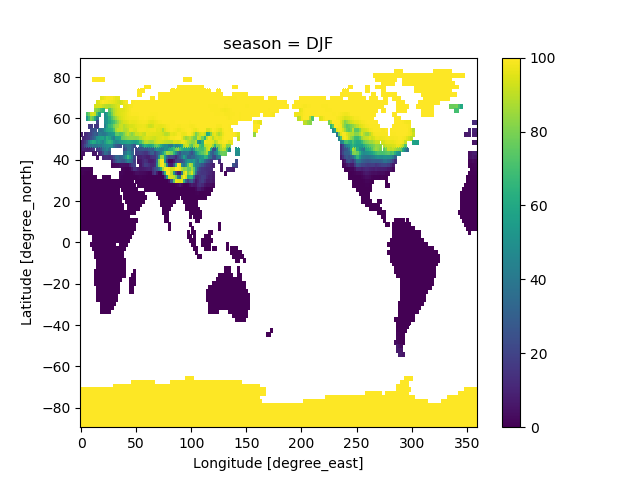

In [61]:
plt.figure()
ds_weighted[0].plot()

In [63]:
test[0]

<xarray.DataArray 'snowc' (lat: 94, lon: 192)>
array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ...,
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.]], dtype=float32)
Coordinates:
  * lat      (lat) float32 88.542 86.6531 84.7532 ... -84.7532 -86.6531 -88.542
  * lon      (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.375 356.25 358.125
    season   <U3 'DJF'

In [64]:
ds_weighted[0]

<xarray.DataArray (lat: 94, lon: 192)>
array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ...,
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.]])
Coordinates:
  * lat      (lat) float32 88.542 86.6531 84.7532 ... -84.7532 -86.6531 -88.542
  * lon      (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.375 356.25 358.125
    season   <U3 'DJF'

<IPython.core.display.Javascript object>


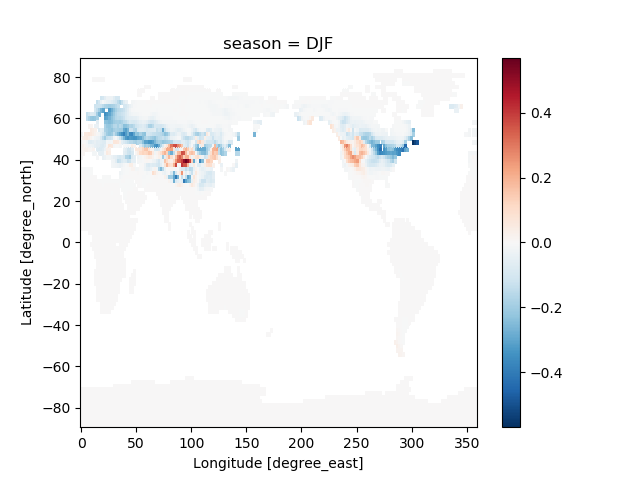

In [62]:
plt.figure()
(ds_weighted[0]-test[0]).plot()